# Reddit Post Embedding Generation

This notebook generates embeddings for Reddit political posts using SentenceTransformers. It's designed to run on Google Colab with GPU support.

In [1]:
#Install required packages
!pip install sentence-transformers tqdm

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import json
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm
import logging
from datetime import datetime
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [4]:
class EmbeddingGenerator:
    def __init__(self, model_name: str = 'all-MiniLM-L6-v2'):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        logger.info(f"Using device: {self.device}")

        self.model = SentenceTransformer(model_name, device=self.device)
        self.model_name = model_name  # Store model name separately
        logger.info(f"Loaded model: {model_name}")

        self.batch_size = 32 if self.device == 'cuda' else 16

    def prepare_texts(self, posts: list) -> list:
        texts = []
        for post in posts:
            text = f"Title: {post['title']}\n\nContent: {post['text']}"
            texts.append(text)
        return texts

    def generate_embeddings(self, posts: list, batch_size: int = None) -> np.ndarray:
        if batch_size is None:
            batch_size = self.batch_size

        texts = self.prepare_texts(posts)
        logger.info(f"Generating embeddings for {len(texts)} posts")

        embeddings = []
        for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
            batch_texts = texts[i:i + batch_size]
            batch_embeddings = self.model.encode(
                batch_texts,
                convert_to_numpy=True,
                show_progress_bar=False
            )
            embeddings.append(batch_embeddings)

        return np.vstack(embeddings)

    def save_data(self, posts: list, embeddings: np.ndarray, output_dir: str):
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)

        # Save embeddings
        embeddings_path = output_dir / 'reddit_embeddings.npy'
        np.save(embeddings_path, embeddings)
        logger.info(f"Saved embeddings to {embeddings_path}")

        # Save metadata
        metadata = {
            'total_posts': len(posts),
            'embedding_dimension': embeddings.shape[1],
            'generated_at': datetime.now().isoformat(),
            'model_name': self.model_name,  # Use stored model name
            'post_types': {
                'recent': len([p for p in posts if p.get('source') == 'recent']),
                'archive': len([p for p in posts if p.get('source') == 'archive'])
            },
            'topics': list(set(p.get('topic') for p in posts if p.get('topic'))),
            'subreddits': list(set(p.get('subreddit') for p in posts))
        }

        metadata_path = output_dir / 'embedding_metadata.json'
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)
        logger.info(f"Saved metadata to {metadata_path}")

        # Save posts with their embeddings
        posts_with_embeddings = []
        for i, post in enumerate(posts):
            post_data = post.copy()
            post_data['embedding_index'] = i
            posts_with_embeddings.append(post_data)

        posts_path = output_dir / 'reddit_posts_with_embeddings.json'
        with open(posts_path, 'w') as f:
            json.dump(posts_with_embeddings, f, indent=2)
        logger.info(f"Saved posts with embedding indices to {posts_path}")

In [5]:
# Set paths
base_path = '/content/drive/MyDrive/MimirTool'
data_path = Path(base_path) / 'app/data'
output_path = Path(base_path) / 'app/data/embeddings'

# Find the most recent data file
data_files = list(data_path.glob('reddit_political_posts_*.json'))
if not data_files:
    raise FileNotFoundError("No data files found")

latest_file = max(data_files, key=lambda x: x.stat().st_mtime)
logger.info(f"Using data file: {latest_file}")

# Load posts
with open(latest_file) as f:
    data = json.load(f)
    posts = data['posts']

print(f"Loaded {len(posts)} posts")

Loaded 9808 posts


In [6]:
# Initialize generator
generator = EmbeddingGenerator()

# Generate embeddings
embeddings = generator.generate_embeddings(posts)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating embeddings:   0%|          | 0/307 [00:00<?, ?it/s]

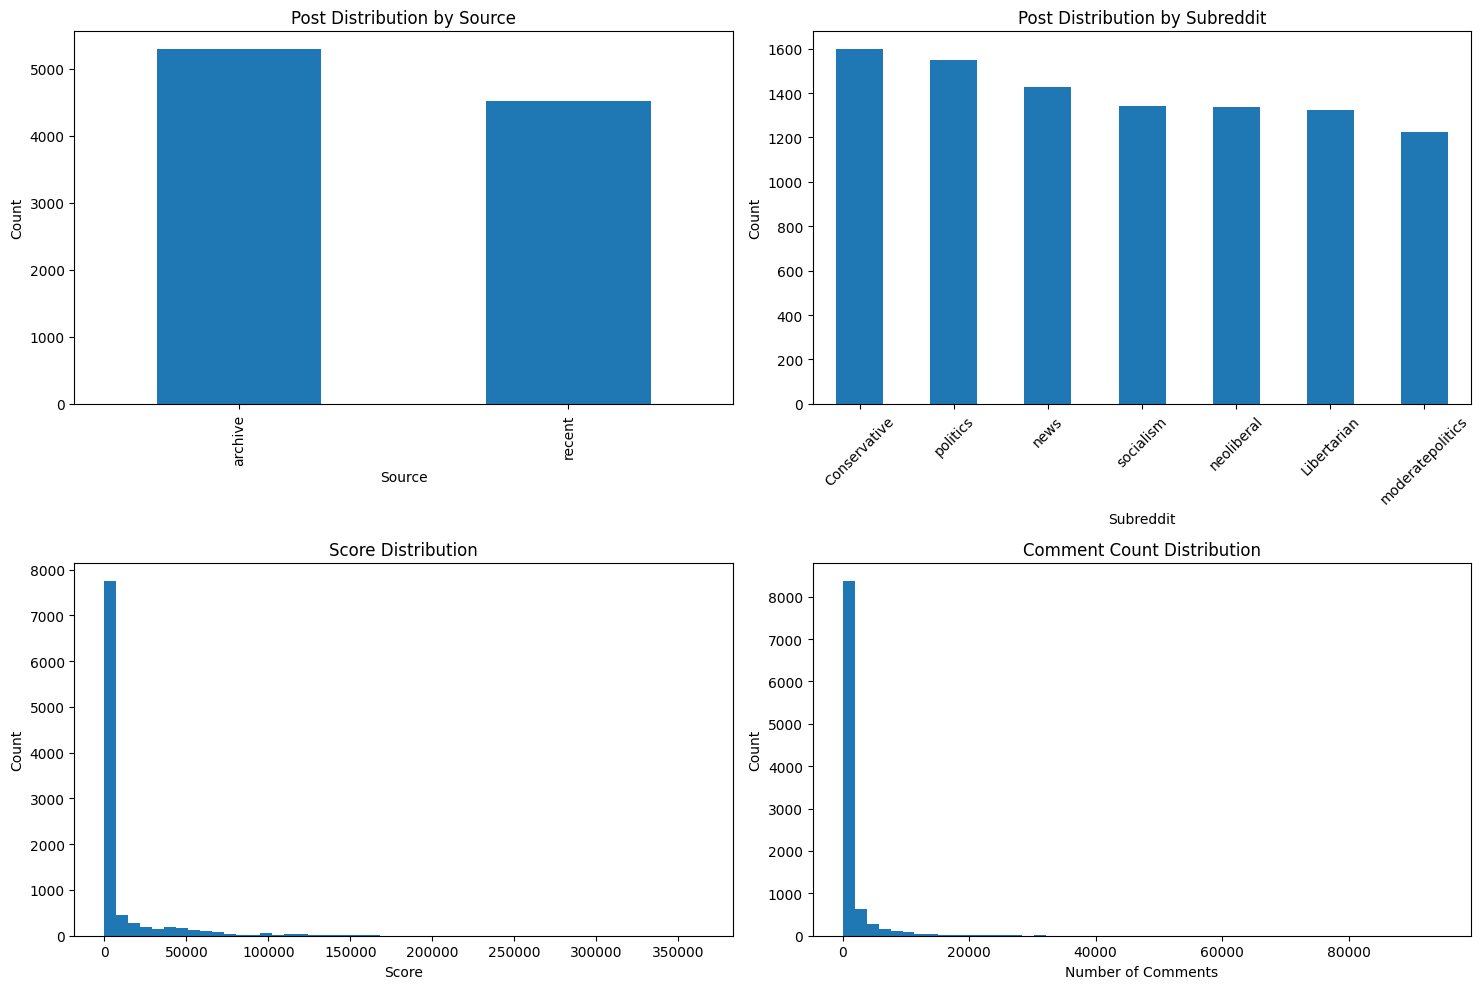


=== Embedding Generation Summary ===

Total posts processed: 9808
Embedding dimension: 384
Output directory: /content/drive/MyDrive/MimirTool/app/data/embeddings

GPU Memory Usage:
Allocated: 94.78 MB
Cached: 372.00 MB


In [7]:
# Save data
generator.save_data(posts, embeddings, output_path)

# Create visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Post Distribution by Source
plt.subplot(2, 2, 1)
source_counts = pd.Series([p.get('source', 'unknown') for p in posts]).value_counts()
source_counts.plot(kind='bar')
plt.title('Post Distribution by Source')
plt.xlabel('Source')
plt.ylabel('Count')

# Plot 2: Post Distribution by Subreddit
plt.subplot(2, 2, 2)
subreddit_counts = pd.Series([p.get('subreddit', 'unknown') for p in posts]).value_counts()
subreddit_counts.plot(kind='bar')
plt.title('Post Distribution by Subreddit')
plt.xticks(rotation=45)
plt.xlabel('Subreddit')
plt.ylabel('Count')

# Plot 3: Score Distribution
plt.subplot(2, 2, 3)
scores = [p.get('score', 0) for p in posts]
plt.hist(scores, bins=50)
plt.title('Score Distribution')
plt.xlabel('Score')
plt.ylabel('Count')

# Plot 4: Comment Count Distribution
plt.subplot(2, 2, 4)
comment_counts = [p.get('num_comments', 0) for p in posts]
plt.hist(comment_counts, bins=50)
plt.title('Comment Count Distribution')
plt.xlabel('Number of Comments')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Print summary
print("\n=== Embedding Generation Summary ===")
print(f"\nTotal posts processed: {len(posts)}")
print(f"Embedding dimension: {embeddings.shape[1]}")
print(f"Output directory: {output_path}")

if torch.cuda.is_available():
    print(f"\nGPU Memory Usage:")
    print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")